#Deep Learning Assignment
###Skin Lesion Classification

Course: Deep Learning, Block 1

Course code: 880008-M-6

Academic Year: 2023-2024


##Group 8
Group Members:
*  Suzy Xie (2096049)
*  Xavier Huijts (2108520)
*  Niels van der Sanden (2082543)
*  Leonardo Tasso (2111433)







In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import os
import random
import pandas as pd
import numpy as np

os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(42)
np.random.seed(42)

os.environ['PYTHONHASHSEED']=str(42)


from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
#import keras_tuner
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import  EarlyStopping
from sklearn.metrics import RocCurveDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
#import keras_tuner as kt
import keras
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Replace these paths with the actual paths to your dataset folders
data_folder = '/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_Input/'

#data_folder = '/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/'
ground_truth_folder = '/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_GroundTruth/'



df = pd.read_csv('/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')

image_data = []
labels = []

for index, row in df.iterrows():
    image_title = row['image']
    label = row.drop('image', axis=0)  # Drop the 'image' column to keep only labels

    image_path = os.path.join(data_folder, image_title + ".jpg")

    try:
        # Open the image using PIL (or you can use OpenCV) within a 'with' statement
        with Image.open(image_path) as image:
            if image is not None:
                # Resize images
                im = image.resize((120,150), Image.LANCZOS)
                # Append image and label to respective lists
                image_data.append(np.array(im))
                labels.append(label)
            else:
                print(f"Error opening image '{image_path}': NoneType object returned")
    except Exception as e:
        print(f"Error opening image '{image_path}': {e}")

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save('/content/drive/MyDrive/DeepLearning/data.npy',image_matrix)
np.save('/content/drive/MyDrive/DeepLearning/labels.npy',tr_labels)

# Class mapping
class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}

# Convert float labels to class names
class_labels = [class_mapping[tuple(label)] for label in tr_labels]
np.save("/content/drive/MyDrive/DeepLearning/labels_name.npy",class_labels)

Once you save your data, you can load it from your directory.

In [ ]:
file_dir = '/content/drive/MyDrive/DeepLearning/'
data = np.load(file_dir + "data.npy")
labels = np.load(file_dir + "labels.npy", allow_pickle=True)
class_labels = np.load(file_dir + "labels_name.npy")

## Preprocessing

In [ ]:
#Division of the dataset in trainig set and test set. The training set here is 'temp', because the validation set still needs to be created
X_train_temp, X_test, y_train_temp, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

#Division of the training set between actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

#Normalization
X_train = X_train/255.0
X_val = X_val/255.0



In [ ]:
y_val

array([[0.0, 0.0, 1.0, ..., 0.0, 0.0, 0.0],
       [0.0, 1.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 1.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 1.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 1.0, 0.0, ..., 0.0, 0.0, 0.0],
       [1.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [ ]:
print(type(y_val))

<class 'numpy.ndarray'>


# Visualizing Sample images

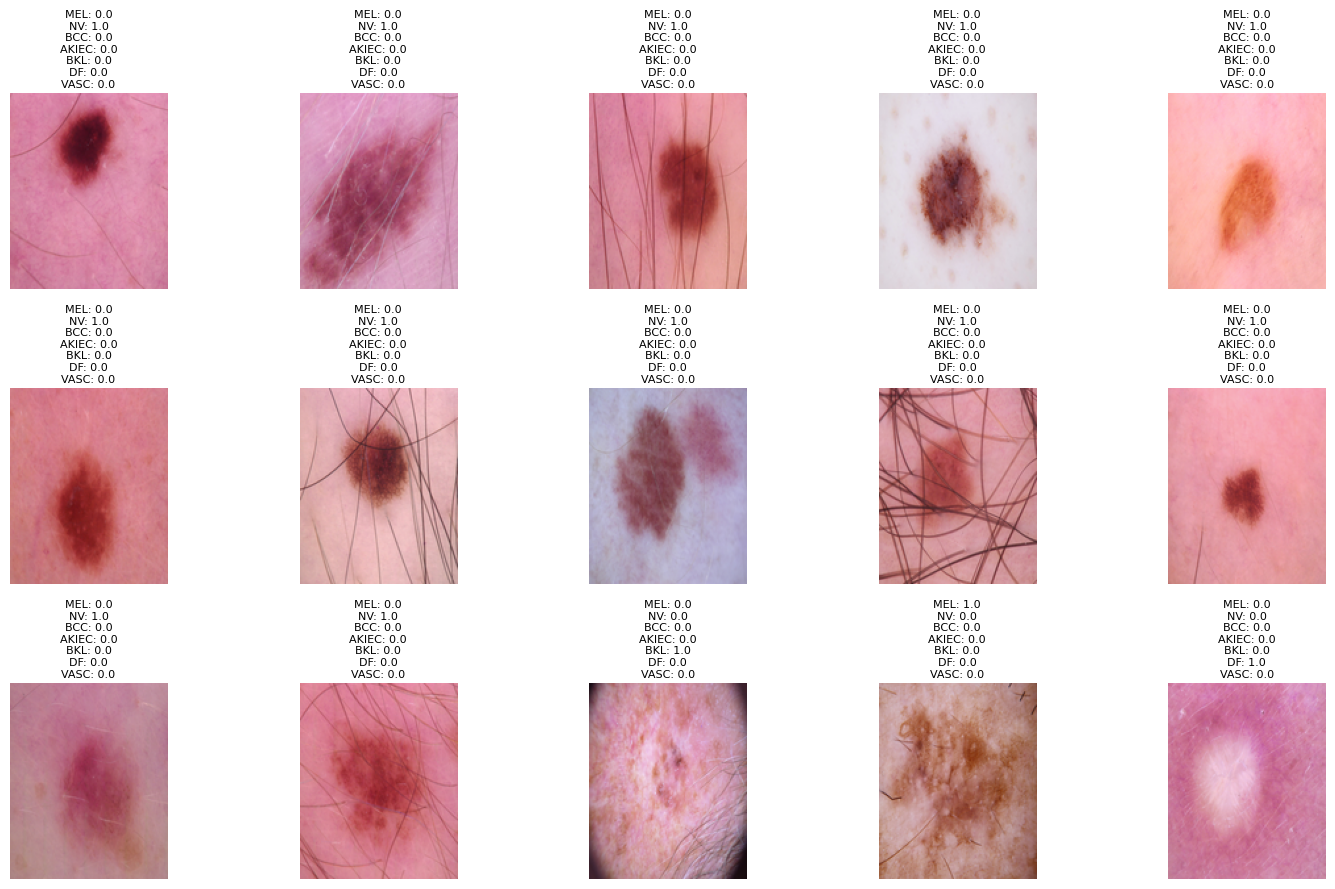

In [ ]:
data_folder = '/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_Input'
ground_truth_folder = '/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_GroundTruth'

df = pd.read_csv('/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')

sampled_df = df.sample(n=15, random_state=42)


fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))

for ax, (index, row) in zip(axes.flatten(), sampled_df.iterrows()):
    image_title = row['image']
    label = row.drop('image', axis=0)

    image_path = os.path.join(data_folder, image_title + ".jpg")

    try:

        with Image.open(image_path) as image:
            if image is not None:
                # Resize images
                im = image.resize((120, 150), Image.LANCZOS)
                im = np.array(im) / 255.0
                # Display the image
                ax.imshow(im)
                ax.axis('off')

                label_text = "\n".join([f"{key}: {value}" for key, value in label.items()])
                ax.text(0.5, 1.02, label_text, transform=ax.transAxes, ha='center', va='bottom', fontsize=8)
            else:
                print(f"Error opening image '{image_path}': NoneType object returned")
    except Exception as e:
        print(f"Error opening image '{image_path}': {e}")

plt.tight_layout()
plt.show()

# Visualize Class Label Distribution

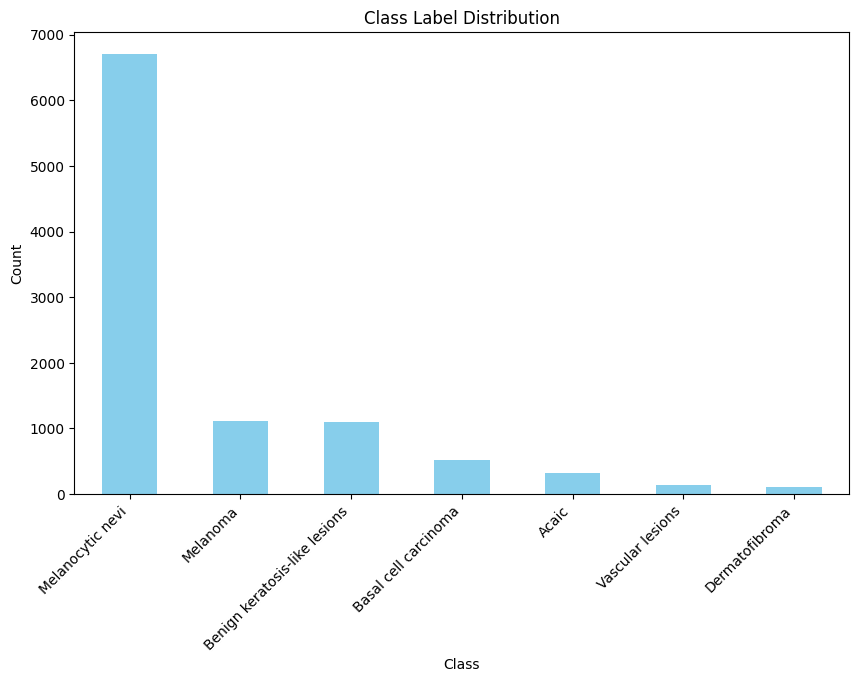

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')


class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}

# Convert float labels to class names
df['Class'] = [class_mapping[tuple(label)] for label in df.iloc[:, 1:].values]

class_counts = df['Class'].value_counts()


plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


# **Baseline Model**

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_val = X_val.astype('float32')
y_val = y_val.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

Shape of X_train: (6409, 150, 120, 3)
Shape of X_val: (1603, 150, 120, 3)


Training Set Class Distribution:
1    5367
4     893
0     874
2     408
3     265
6     112
5      93
dtype: int64

Validation Set Class Distribution:
1    1084
4     184
0     162
2      75
3      53
6      26
5      19
dtype: int64

Testing Set Class Distribution:
1    1338
0     239
4     206
2     106
3      62
6      30
5      22
dtype: int64


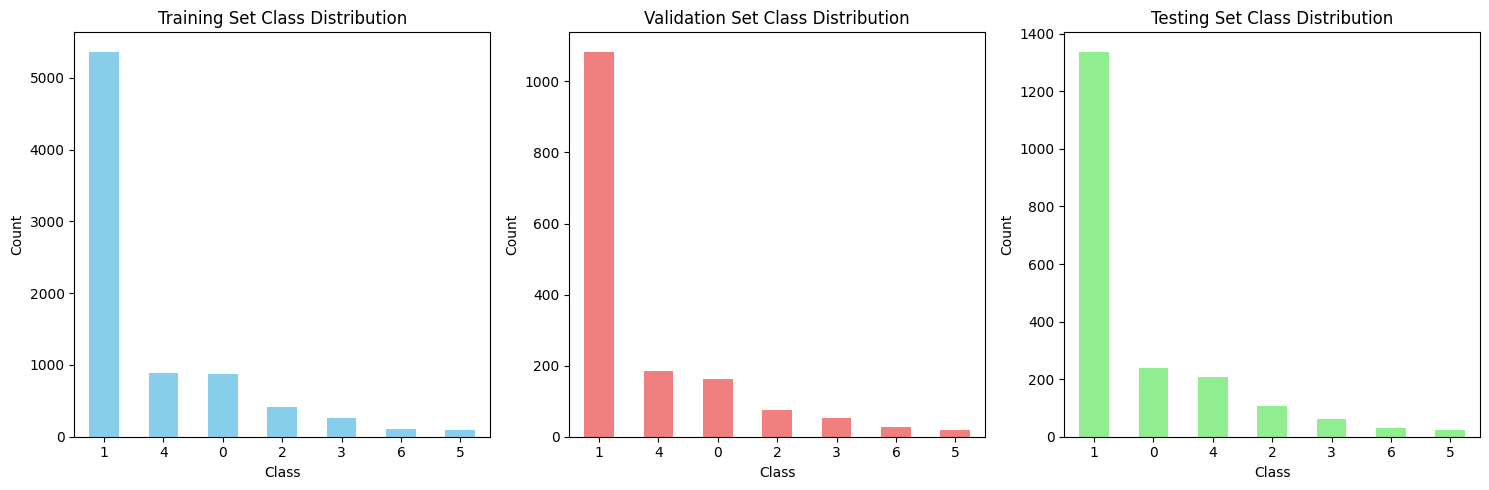

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert multi-class labels to class labels
y_train_class_labels = np.argmax(y_train_temp, axis=1)
y_val_class_labels = np.argmax(y_val, axis=1)
y_test_class_labels = np.argmax(y_test, axis=1)

# Count class occurrences in the class labels
class_counts_training = pd.Series(y_train_class_labels).value_counts()
class_counts_validation = pd.Series(y_val_class_labels).value_counts()
class_counts_testing = pd.Series(y_test_class_labels).value_counts()

# Print class counts
print("Training Set Class Distribution:")
print(class_counts_training)
print("\nValidation Set Class Distribution:")
print(class_counts_validation)
print("\nTesting Set Class Distribution:")
print(class_counts_testing)

# Create bar plots to visualize the class distribution
plt.figure(figsize=(15, 5))

plt.subplot(131)
class_counts_training.plot(kind='bar', color='skyblue')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(132)
class_counts_validation.plot(kind='bar', color='lightcoral')
plt.title('Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(133)
class_counts_testing.plot(kind='bar', color='lightgreen')
plt.title('Testing Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


# **Baseline Model (Using Normal Data Set)**

In [ ]:
model = Sequential()

# Set the random seed to ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#Block 1:
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 120, 3), padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

#Block 2:
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

#Flatten:
model.add(layers.Flatten())

#Add 2 Dense layers with 32 units and the output layer
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

#Compile
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 120, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 120, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 30, 32)        0         
 g2D)                                                   

Baseline Model: Loss/Accuracy plot

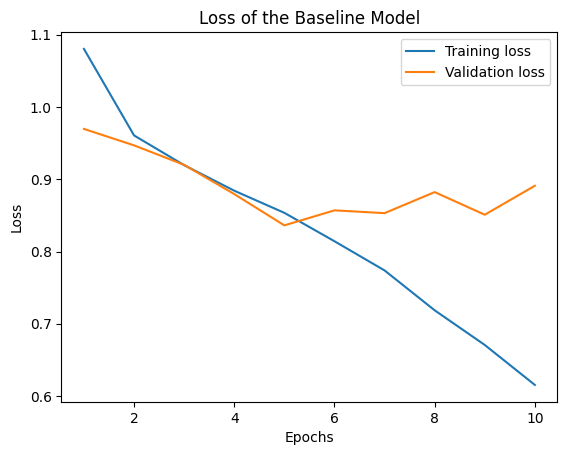

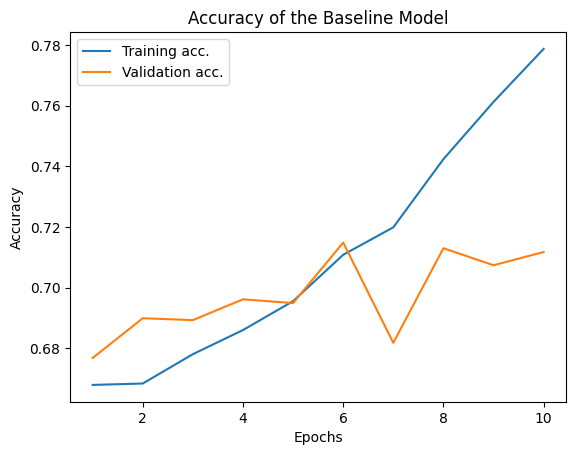

In [ ]:
history_dict = history.history

#plot the training loss and validation loss

def plot_history(data_list, label_list, title, ylabel):
    ''' Plots a list of vectors.

    Parameters:
        data_list  : list of vectors containing the values to plot
        label_list : list of labels describing the data, one per vector
        title      : title of the plot
        ylabel     : label for the y axis
    '''
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Loss of the Baseline Model',
             ylabel='Loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Accuracy of the Baseline Model',
             ylabel='Accuracy')

Baseline Model: Confusion Matrix on Validation Set

51/51 [==============================] - 1s 16ms/step


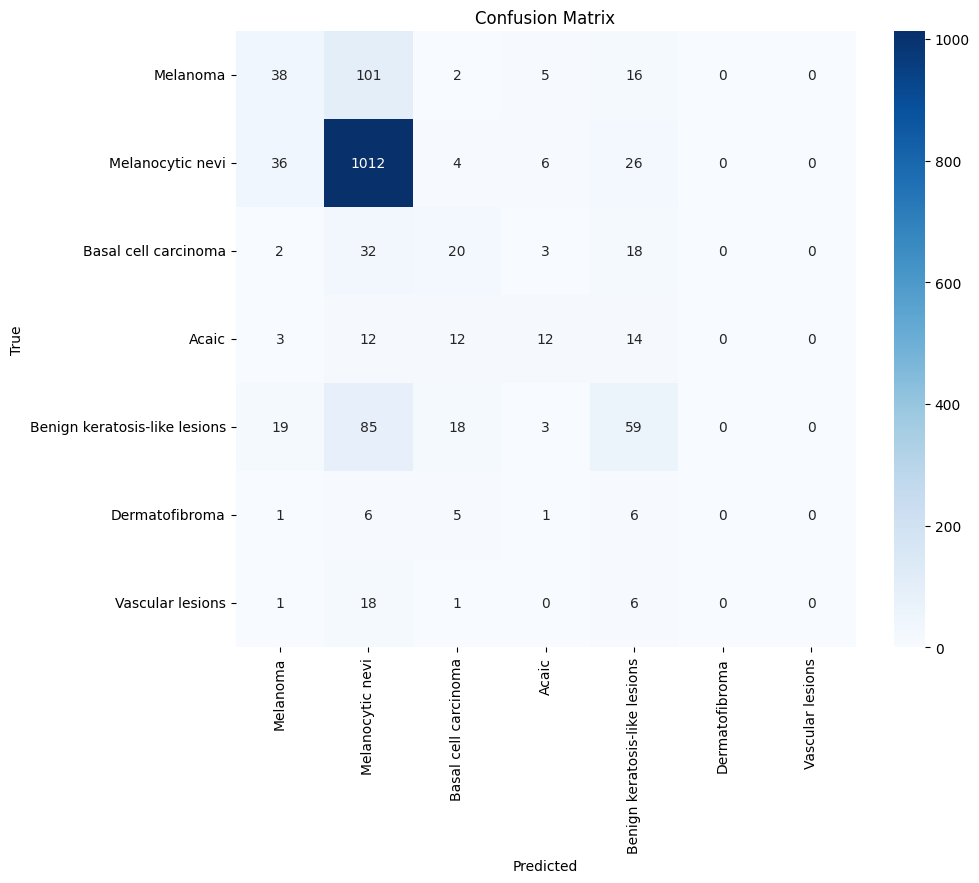

In [ ]:
class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)


confusion_mtx = confusion_matrix(y_val_classes, y_pred_classes)

#Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Baseline: Confusion Matrix on Test Set

63/63 [==============================] - 1s 13ms/step


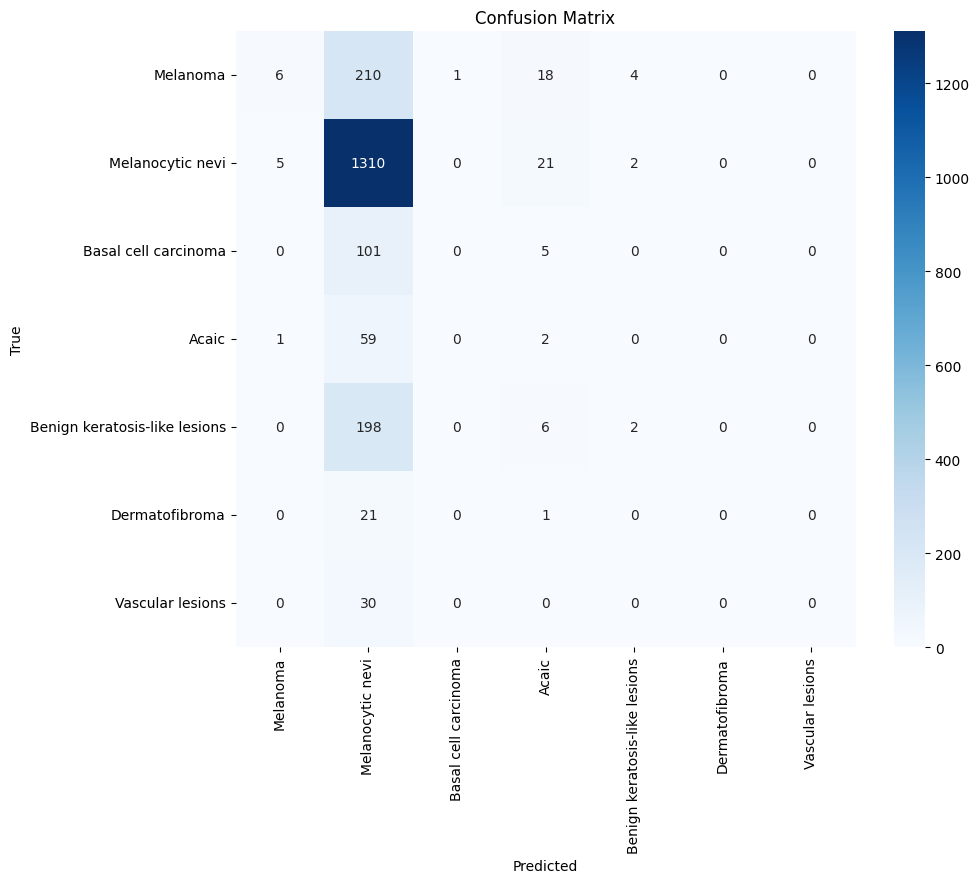

In [ ]:
#test set confusin matrix
class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

#Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 [==============================] - 1s 19ms/step - loss: 133.2923 - accuracy: 0.6590
Test Loss: 133.2922821044922
Test Accuracy: 0.6590114831924438


Baseline Model: Recall, Precision, F1

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Convert predictions and true labels to classes
y_test_classes = np.argmax(y_test, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_classes, y_pred_test_classes, average=None)
recall = recall_score(y_test_classes, y_pred_test_classes, average=None)
f1 = f1_score(y_test_classes, y_pred_test_classes, average=None)

n_classes = len(np.unique(y_test_classes))

for i in range(n_classes):
    print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")

# If you want micro, macro, or weighted averages, you can use:
precision_micro = precision_score(y_test_classes, y_pred_test_classes, average='micro')
recall_micro = recall_score(y_test_classes, y_pred_test_classes, average='micro')
f1_micro = f1_score(y_test_classes, y_pred_test_classes, average='micro')

precision_macro = precision_score(y_test_classes, y_pred_test_classes, average='macro')
recall_macro = recall_score(y_test_classes, y_pred_test_classes, average='macro')
f1_macro = f1_score(y_test_classes, y_pred_test_classes, average='macro')

precision_weighted = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
recall_weighted = recall_score(y_test_classes, y_pred_test_classes, average='weighted')
f1_weighted = f1_score(y_test_classes, y_pred_test_classes, average='weighted')

print("\nMicro Average - Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision_micro, recall_micro, f1_micro))
print("Macro Average - Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision_macro, recall_macro, f1_macro))
print("Weighted Average - Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision_weighted, recall_weighted, f1_weighted))


63/63 [==============================] - 1s 14ms/step
Class 0 - Precision: 0.5000, Recall: 0.0251, F1 Score: 0.0478
Class 1 - Precision: 0.6791, Recall: 0.9791, F1 Score: 0.8020
Class 2 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class 3 - Precision: 0.0377, Recall: 0.0323, F1 Score: 0.0348
Class 4 - Precision: 0.2500, Recall: 0.0097, F1 Score: 0.0187
Class 5 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class 6 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000

Micro Average - Precision: 0.6590, Recall: 0.6590, F1 Score: 0.6590
Macro Average - Precision: 0.2095, Recall: 0.1494, F1 Score: 0.1290
Weighted Average - Precision: 0.5402, Recall: 0.6590, F1 Score: 0.5444


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline Model: ROC Curve on Validation Data

51/51 [==============================] - 1s 15ms/step


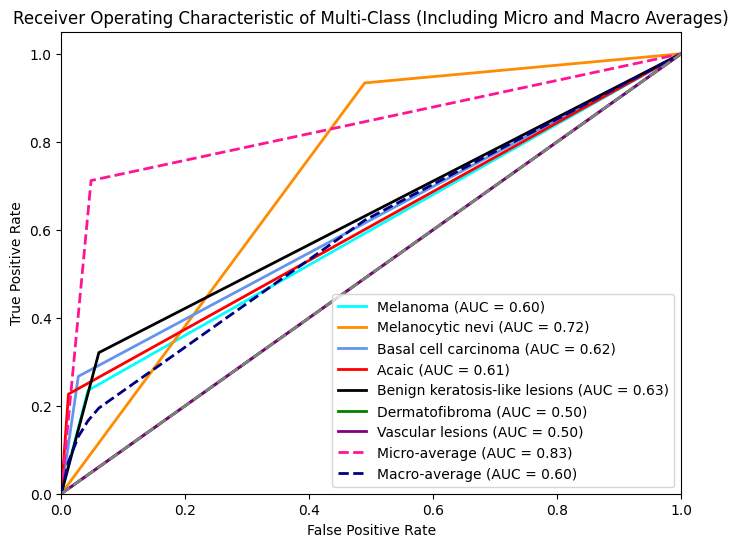

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Assuming you have already defined X_val and y_val

# Retrieve the predictions and true labels
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Binarize the predicted and true labels (similar to hot-hand-encoding)
n_classes = len(np.unique(y_val_classes))
y_true_hot_hand = label_binarize(y_val_classes, classes=np.arange(n_classes))
y_pred_hot_hand = label_binarize(y_pred_classes, classes=np.arange(n_classes))

# Initialize lists to store FPR, TPR, and AUC for each class
fp_r = []
tp_r = []
roc_auc = []

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fp_r_i, tp_r_i, _ = roc_curve(y_true_hot_hand[:, i], y_pred_hot_hand[:, i])
    roc_auc_i = auc(fp_r_i, tp_r_i)

    fp_r.append(fp_r_i)
    tp_r.append(tp_r_i)
    roc_auc.append(roc_auc_i)

# Calculate micro-average FPR and TPR
micro_fpr, micro_tpr, _ = roc_curve(y_true_hot_hand.ravel(), y_pred_hot_hand.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Calculate macro-average FPR and TPR
macro_fpr = np.unique(np.concatenate([fp_r[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(macro_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(macro_fpr, fp_r[i], tp_r[i])
mean_tpr /= n_classes
macro_auc = auc(macro_fpr, mean_tpr)

plt.figure(figsize=(8, 6))

# Define line styles and colors for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'black', 'green', 'purple'])
class_names = ["Melanoma", "Melanocytic nevi", "Basal cell carcinoma", "Acaic", "Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fp_r[i], tp_r[i], color=color, lw=2, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(micro_fpr, micro_tpr, color='deeppink', linestyle='--', lw=2, label=f'Micro-average (AUC = {micro_auc:.2f})')

# Plot macro-average ROC curve
plt.plot(macro_fpr, mean_tpr, color='navy', linestyle='--', lw=2, label=f'Macro-average (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Multi-Class (Including Micro and Macro Averages)')
plt.legend(loc='lower right')
plt.show()


Baseline Model: ROC Curve on Test Data

63/63 [==============================] - 1s 17ms/step


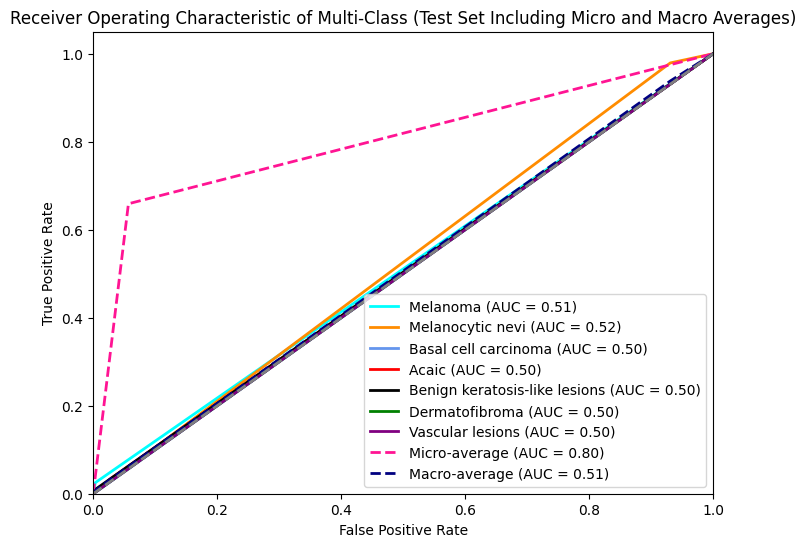

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np



# Retrieve the predictions and true labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Binarize the predicted and true labels (similar to hot-hand-encoding)
n_classes = len(np.unique(y_test_classes))
y_true_hot_hand = label_binarize(y_test_classes, classes=np.arange(n_classes))
y_pred_hot_hand = label_binarize(y_pred_classes, classes=np.arange(n_classes))

# Initialize lists to store FPR, TPR, and AUC for each class
fp_r = []
tp_r = []
roc_auc = []

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fp_r_i, tp_r_i, _ = roc_curve(y_true_hot_hand[:, i], y_pred_hot_hand[:, i])
    roc_auc_i = auc(fp_r_i, tp_r_i)

    fp_r.append(fp_r_i)
    tp_r.append(tp_r_i)
    roc_auc.append(roc_auc_i)

# Calculate micro-average FPR and TPR
micro_fpr, micro_tpr, _ = roc_curve(y_true_hot_hand.ravel(), y_pred_hot_hand.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Calculate macro-average FPR and TPR
macro_fpr = np.unique(np.concatenate([fp_r[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(macro_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(macro_fpr, fp_r[i], tp_r[i])
mean_tpr /= n_classes
macro_auc = auc(macro_fpr, mean_tpr)

plt.figure(figsize=(8, 6))

# Define line styles and colors for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'black', 'green', 'purple'])
class_names = ["Melanoma", "Melanocytic nevi", "Basal cell carcinoma", "Acaic", "Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fp_r[i], tp_r[i], color=color, lw=2, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(micro_fpr, micro_tpr, color='deeppink', linestyle='--', lw=2, label=f'Micro-average (AUC = {micro_auc:.2f})')

# Plot macro-average ROC curve
plt.plot(macro_fpr, mean_tpr, color='navy', linestyle='--', lw=2, label=f'Macro-average (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Multi-Class (Test Set Including Micro and Macro Averages)')
plt.legend(loc='lower right')
plt.show()

# **Data Augmentation**

Generate Augmented Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
df['Class'] = df[[ 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)
df['image'] = '/content/drive/MyDrive/DeepLearning/ISIC2018_Task3_Training_Input/'+df['image']+'.jpg'

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest',
    rescale=1./255
)



train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

image_size = (120, 150)

# Flow from DataFrame with augmentation
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='Class',
    target_size=image_size,
    class_mode='categorical',
    batch_size= 32,
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col='Class',
    target_size=image_size,
    class_mode='categorical',
    batch_size= 32,
    shuffle=False
)


test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='Class',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6409 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


Augmented Data: Testing Using Baseline Model

In [ ]:
#fit the generated data to baseline model
model = Sequential()


model.add(layers.Conv2D(64, (3, 3), activation= 'relu', input_shape=(150, 120, 3), padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation= 'relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation= 'relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation= 'relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())


model.add(layers.Dense(32, activation= 'relu'))
model.add(layers.Dense(32, activation= 'relu'))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=10,
                    validation_data=val_generator,
                    callbacks = early_stop)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 120, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 120, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 30, 32)        0         
 g2D)                                                   

# **Down-sampling the Majority Class**

Equal Class-Weights Method

In [ ]:
class_weights = compute_class_weight(class_weight ='balanced',
                                  classes = np.unique(np.argmax(y_train, axis=1)),
                                  y= np.argmax(y_train, axis=1))
class_weights_dict = dict(enumerate(class_weights))

model = Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 120, 3), padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model with class weights
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    class_weight= class_weights_dict)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 120, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 120, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 30, 32)        0         
 g2D)                                                   

Under-Sampling the Majority Class Method

In [ ]:
# Reshape y_train to a 1D array
y_train_labels = np.argmax(y_train, axis=1)

# Identify the majority class
majority_class = np.argmax(np.sum(y_train, axis=0))

# Separate data by class
majority_data = X_train[y_train_labels == majority_class]
minority_data = X_train[y_train_labels != majority_class]
majority_labels = y_train_labels[y_train_labels == majority_class]
minority_labels = y_train_labels[y_train_labels != majority_class]

# Undersample majority class to match the minority class
undersampled_majority_data = resample(majority_data, replace=False, n_samples=len(minority_data), random_state=42)
undersampled_majority_labels = np.full(len(undersampled_majority_data), majority_class)

# Combine minority class and undersampled majority class
undersampled_X_train = np.concatenate([minority_data, undersampled_majority_data])
undersampled_y_train_labels = np.concatenate([minority_labels, undersampled_majority_labels])

# Convert labels back to one-hot encoded format
undersampled_y_train = np.eye(7)[undersampled_y_train_labels]

model = Sequential()


model.add(layers.Conv2D(64, (3, 3), activation= 'relu', input_shape=(150, 120, 3), padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation= 'relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation= 'relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation= 'relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())


model.add(layers.Dense(32, activation= 'relu'))
model.add(layers.Dense(32, activation= 'relu'))
model.add(layers.Dense(7, activation='softmax'))



model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    undersampled_X_train, undersampled_y_train,
    epochs= 10,
    batch_size=32,
    validation_data=(X_val, y_val),

)


Epoch 1/10
133/133 [==============================] - 26s 99ms/step - loss: 1.3638 - accuracy: 0.5087 - val_loss: 1.0735 - val_accuracy: 0.6176
Epoch 2/10
133/133 [==============================] - 11s 84ms/step - loss: 1.2169 - accuracy: 0.5423 - val_loss: 0.9132 - val_accuracy: 0.6818
Epoch 3/10
133/133 [==============================] - 11s 84ms/step - loss: 1.1680 - accuracy: 0.5593 - val_loss: 0.9995 - val_accuracy: 0.6650
Epoch 4/10
133/133 [==============================] - 12s 87ms/step - loss: 1.1368 - accuracy: 0.5600 - val_loss: 0.8926 - val_accuracy: 0.6719
Epoch 5/10
133/133 [==============================] - 11s 86ms/step - loss: 1.0918 - accuracy: 0.5835 - val_loss: 0.8991 - val_accuracy: 0.6825
Epoch 6/10
133/133 [==============================] - 11s 85ms/step - loss: 1.0629 - accuracy: 0.5898 - val_loss: 0.8840 - val_accuracy: 0.6644
Epoch 7/10
133/133 [==============================] - 12s 90ms/step - loss: 1.0304 - accuracy: 0.6030 - val_loss: 0.8436 - val_accuracy:

# **Hyper-parameter Tuning**

Tune the number of CNN/Dense layers and its correspoding Filters/Neurons are tuned separately. See in the below the candidate values:

- Number of CNN layers:                   [3, 4, 5,]
- Number of filters for each CNN layer:   [16, 32, 48, 64]
- Number of Dense layers:                 [1, 2, 3]
- Number of Neurons for each Dense layer: [16, 32, 48, 64]



In [ ]:
pip install keras-tuner

In [ ]:
from kerastuner.tuners import BayesianOptimization
# Define a function to build the model with tunable hyperparameters
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(150, 120, 3)))  # Input layer

    # Determine the number of CNN layers
    num_cnn_layers = hp.Int('num_cnn_layers', min_value=2, max_value=6, step=2)

    # Determine the number of filters for all CNN layers
    filters = hp.Int('filters', min_value=16, max_value=64, step=16)

    for i in range(num_cnn_layers):
        model.add(layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation='relu',
            padding='same'
        ))
        if (i + 1) % 2 == 0:  # Add MaxPooling after every 2 CNN layers
            model.add(layers.MaxPooling2D((2, 2)))  # MaxPooling layer with (2, 2) pool size

    model.add(layers.Flatten())

    # Determine the number of Dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=4, step=1)

    # Determine the number of neurons for all Dense layers
    neurons = hp.Choice('neurons', values=[16, 32, 48, 64])

    for i in range(num_dense_layers):
        model.add(layers.Dense(
            units=neurons,
            activation='relu'  # Activation function is fixed to 'relu'
        ))

    model.add(layers.Dense(7, activation='softmax'))

    # Compile the model with Adam optimizer
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=2,  # Number of hyperparameter combinations to try
    num_initial_points=10,  # Number of random initial points
    directory='my_tuner_directory',
    project_name='my_tuner_project',
    overwrite = True
)


# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

y_test = y_test.astype(int)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

#Evaluate and print the best model's accuracy
best_model_accuracy = best_model.evaluate(X_test, y_test)[1]
print("Best Model:")
best_model.summary()
print(f"Best Model Accuracy on Test Data: {best_model_accuracy}")

#Print the corresponding hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(f"Number of CNN Layers: {best_hyperparameters.get('num_cnn_layers')}")
print(f"Number of Filters: {best_hyperparameters.get('filters')}")
print(f"Number of Dense Layers: {best_hyperparameters.get('num_dense_layers')}")
print(f"Number of Neurons in Dense Layers: {best_hyperparameters.get('neurons')}")


ModuleNotFoundError: ignored

The number of CNN and Dense layers are optimized saparately in the previous block, including their corresponding number of Filters and Neurons. Now the following HP's will be tuned, see in the below the possible values considered:

- Activation function: ['Relu', 'Sigmoid']
- Optimizors:          ['Adam', 'SGD']
- Learning rate:       
        If Optimizor=Adam:
                       [0.0005, 0.00075, 0.001, 0.00125, 0.0015]
        If Optimizor=SGD:
                       [0.005,0.0075, 0.01, 0.0125, 0.015]
- Dropout rate:        [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]



In [ ]:
from kerastuner.tuners import BayesianOptimization

# Define a function to build the model with tunable hyperparameters
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(150, 120, 3)))  # Input layer

    # Fixed number of CNN layers and filters
    num_cnn_layers = 4
    filters = 16

    for i in range(num_cnn_layers):
        # Choose between 'relu' and 'sigmoid' activation functions
        activation = hp.Choice('activation', values=['relu', 'Sigmoid'])

        model.add(layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=activation,  # Use the selected activation function
            padding='same'
        ))
        if (i + 1) % 2 == 0:  # Add MaxPooling after every 2 CNN layers
            model.add(layers.MaxPooling2D((2, 2)))  # MaxPooling layer with (2, 2) pool size

    model.add(layers.Flatten())

    # Fixed number of Dense layers and neurons
    num_dense_layers = 2
    neurons = 48

    for i in range(num_dense_layers):
        model.add(layers.Dense(
            units=neurons,
            activation=hp.Choice('activation', values=['relu', 'Sigmoid'])  # Use the selected activation function
        ))

        model.add(layers.Dropout(hp.Choice('dropout', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))

    model.add(layers.Dense(7, activation='softmax'))

    # Compile the model with tunable hyperparameters
    optimizer = hp.Choice('optimizer', values=['Adam', 'SGD'])
    learning_rate = hp.Choice('learning_rate', values=[0.0005, 0.00075, 0.001, 0.00125, 0.0015])

    if optimizer == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    num_initial_points=10,  # Number of random initial points
    directory='my_tuner_directory',
    project_name='my_tuner_project',
    overwrite = True
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Validation Accuracy: {tuner.oracle.get_best_trials(1)[0].score}")
print(f"Best Hyperparameters: {tuner.oracle.get_best_trials(1)[0].hyperparameters.values}")
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

# **Optimised Model: test on Validation set.**

All our tuned hyper-parameter valyes:
-  Number of CNN layers:   4
-  NUmber of Filters:      16
-  Number of Dense layers: 2
-  Number of Neurons:      48
-  Activation Function:    'ReLu'
-  Dropout Rate:           0.0
-  Optimizer:              'Adam'
-  Learning Rate:          0.00075

In [ ]:
model = Sequential()

# Set the random seed to ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#Block 1:
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 120, 3), padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

#Block 2:
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

#Flatten:
model.add(layers.Flatten())

#Add 2 Dense layers with 32 units and the output layer
model.add(layers.Dense(48, activation='relu'))
model.add(layers.Dense(48, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

#Compile
optimizer = Adam(learning_rate=0.00075)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 120, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 120, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 60, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 60, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 60, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 30, 16)        0         
 g2D)                                                   

In [ ]:
#test set confusin matrix
class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_val, axis=1)


confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

#Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Enhanced Model: Accuracy & Loss (on Test set)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 [==============================] - 1s 15ms/step - loss: 366.5961 - accuracy: 0.6231
Test Loss: 366.5960693359375
Test Accuracy: 0.6230654120445251


Enhanced Mode: Recall, Precision, & F1 (on Test set)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Convert predictions and true labels to classes
y_test_classes = np.argmax(y_test, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_classes, y_pred_test_classes, average=None)
recall = recall_score(y_test_classes, y_pred_test_classes, average=None)
f1 = f1_score(y_test_classes, y_pred_test_classes, average=None)

n_classes = len(np.unique(y_test_classes))

for i in range(n_classes):
    print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")

# If you want micro, macro, or weighted averages, you can use:
precision_micro = precision_score(y_test_classes, y_pred_test_classes, average='micro')
recall_micro = recall_score(y_test_classes, y_pred_test_classes, average='micro')
f1_micro = f1_score(y_test_classes, y_pred_test_classes, average='micro')

precision_macro = precision_score(y_test_classes, y_pred_test_classes, average='macro')
recall_macro = recall_score(y_test_classes, y_pred_test_classes, average='macro')
f1_macro = f1_score(y_test_classes, y_pred_test_classes, average='macro')

precision_weighted = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
recall_weighted = recall_score(y_test_classes, y_pred_test_classes, average='weighted')
f1_weighted = f1_score(y_test_classes, y_pred_test_classes, average='weighted')

print("\nMicro Average - Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision_micro, recall_micro, f1_micro))
print("Macro Average - Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision_macro, recall_macro, f1_macro))
print("Weighted Average - Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision_weighted, recall_weighted, f1_weighted))


63/63 [==============================] - 1s 13ms/step
Class 0 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class 1 - Precision: 0.7316, Recall: 0.9043, F1 Score: 0.8088
Class 2 - Precision: 0.2593, Recall: 0.1321, F1 Score: 0.1750
Class 3 - Precision: 0.0569, Recall: 0.2581, F1 Score: 0.0933
Class 4 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class 5 - Precision: 0.2500, Recall: 0.0455, F1 Score: 0.0769
Class 6 - Precision: 0.7778, Recall: 0.2333, F1 Score: 0.3590

Micro Average - Precision: 0.6231, Recall: 0.6231, F1 Score: 0.6231
Macro Average - Precision: 0.2965, Recall: 0.2248, F1 Score: 0.2161
Weighted Average - Precision: 0.5186, Recall: 0.6231, F1 Score: 0.5587


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Enhanced Model: Confusion Matrix using Test set

63/63 [==============================] - 0s 7ms/step


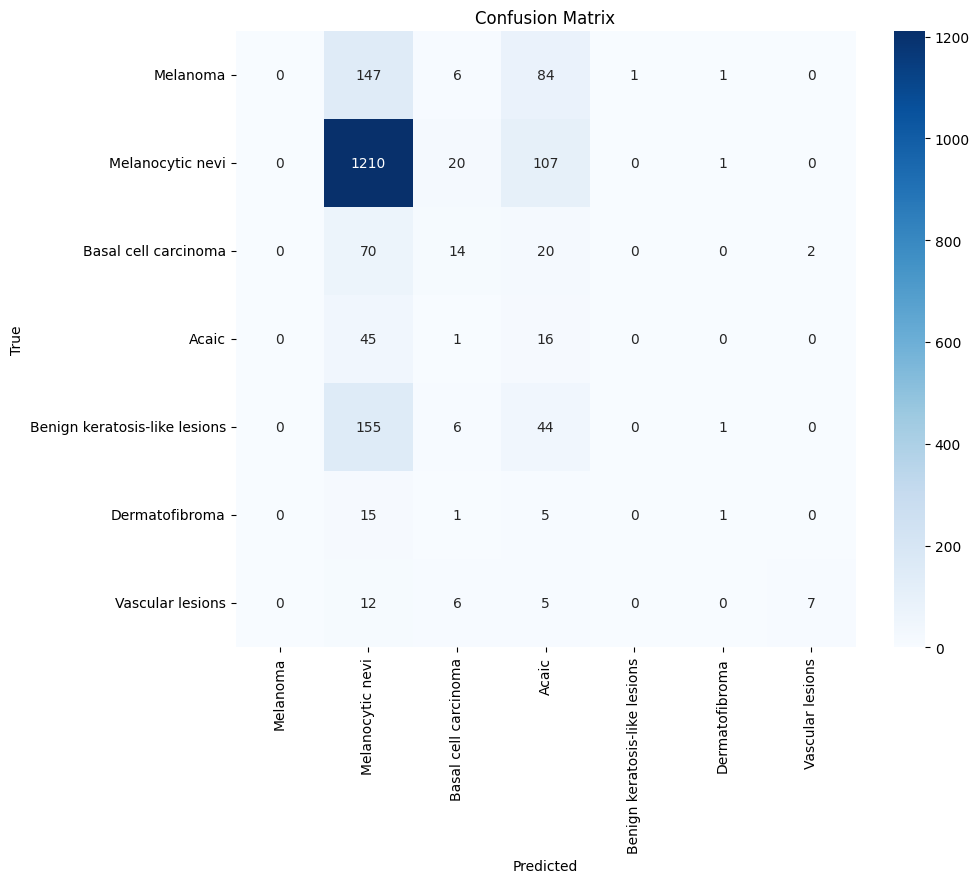

In [ ]:
#test set confusin matrix
class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

#Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Enhanced Model:  AUC-ROC of Test Set Results

63/63 [==============================] - 1s 7ms/step


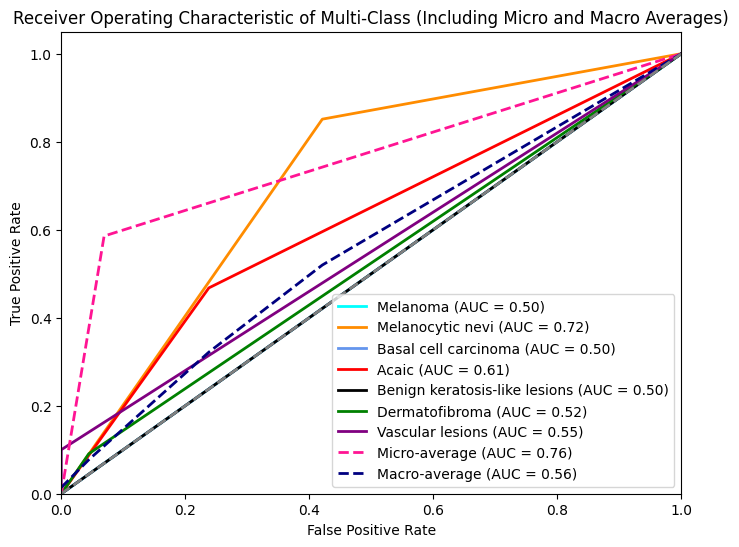

In [ ]:
# Assuming you have already defined X_test and y_test

# Retrieve the predictions and true labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Binarize the predicted and true labels (similar to hot-hand-encoding)
n_classes = len(np.unique(y_test_classes))
y_true_hot_hand = label_binarize(y_test_classes, classes=np.arange(n_classes))
y_pred_hot_hand = label_binarize(y_pred_classes, classes=np.arange(n_classes))

# Initialize lists to store FPR, TPR, and AUC for each class
fp_r = []
tp_r = []
roc_auc = []

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fp_r_i, tp_r_i, _ = roc_curve(y_true_hot_hand[:, i], y_pred_hot_hand[:, i])
    roc_auc_i = auc(fp_r_i, tp_r_i)

    fp_r.append(fp_r_i)
    tp_r.append(tp_r_i)
    roc_auc.append(roc_auc_i)

# Calculate micro-average FPR and TPR
micro_fpr, micro_tpr, _ = roc_curve(y_true_hot_hand.ravel(), y_pred_hot_hand.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Calculate macro-average FPR and TPR
macro_fpr = np.unique(np.concatenate([fp_r[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(macro_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(macro_fpr, fp_r[i], tp_r[i])
mean_tpr /= n_classes
macro_auc = auc(macro_fpr, mean_tpr)

plt.figure(figsize=(8, 6))

# Define line styles and colors for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'black', 'green', 'purple'])
class_names = ["Melanoma", "Melanocytic nevi", "Basal cell carcinoma", "Acaic", "Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fp_r[i], tp_r[i], color=color, lw=2, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(micro_fpr, micro_tpr, color='deeppink', linestyle='--', lw=2, label=f'Micro-average (AUC = {micro_auc:.2f})')

# Plot macro-average ROC curve
plt.plot(macro_fpr, mean_tpr, color='navy', linestyle='--', lw=2, label=f'Macro-average (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Multi-Class (Including Micro and Macro Averages)')
plt.legend(loc='lower right')
plt.show()



# **Transfer Learning Model**

Tranfer Learning Model: Implementing looping

In [ ]:
#Basemodel for transfer learning: VGG neural network
transfer_model = tf.keras.applications.VGG16(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
)

#Freezing the acutal weights -> the pre-existing layers of the model won't change with the new data as input
transfer_model.trainable = False

#Adding some other layers close to the outpute of the model
x = transfer_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dense(256, activation = 'relu')(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
preds = keras.layers.Dense(7, activation = 'softmax')(x) #output layer for 7 classes

final_model = keras.Model(inputs = transfer_model.input, outputs = preds)



58889256/58889256 [==============================] - 0s 0us/step


Final Tranfer Learning Model: Summary

In [ ]:
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Transfer learning model compilation

In [ ]:
epochs = 10

optimizer = Adam(learning_rate=.0001)

final_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

input_shape = (224, 224)

#Resize the images for compatibility with the TL model
X_train_resized = tf.image.resize(X_train, size=input_shape)
X_val_resized = tf.image.resize(X_val, size=input_shape)

#Convert the variable types in tensors for making there compatible with the model
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
X_train_tensor = tf.convert_to_tensor(X_train_resized)
X_val_tensor = tf.convert_to_tensor(X_val_resized)
y_train_tensor = tf.convert_to_tensor(y_train)
y_val_tensor = tf.convert_to_tensor(y_val)

#model fit
final_model.fit(X_train_tensor, y_train_tensor, epochs=epochs, batch_size=32, validation_data=(X_val_tensor, y_val_tensor))

Epoch 1/10
201/201 [==============================] - 49s 185ms/step - loss: 1.1619 - accuracy: 0.6446 - val_loss: 1.0032 - val_accuracy: 0.6762
Epoch 2/10
201/201 [==============================] - 35s 176ms/step - loss: 0.9732 - accuracy: 0.6789 - val_loss: 0.9407 - val_accuracy: 0.6906
Epoch 3/10
201/201 [==============================] - 37s 183ms/step - loss: 0.9303 - accuracy: 0.6858 - val_loss: 0.9176 - val_accuracy: 0.6806
Epoch 4/10
201/201 [==============================] - 37s 181ms/step - loss: 0.9140 - accuracy: 0.6842 - val_loss: 0.8969 - val_accuracy: 0.6912
Epoch 5/10
201/201 [==============================] - 32s 161ms/step - loss: 0.8968 - accuracy: 0.6873 - val_loss: 0.8851 - val_accuracy: 0.6943
Epoch 6/10
201/201 [==============================] - 33s 162ms/step - loss: 0.8849 - accuracy: 0.6893 - val_loss: 0.8904 - val_accuracy: 0.6812
Epoch 7/10
201/201 [==============================] - 32s 162ms/step - loss: 0.8742 - accuracy: 0.6898 - val_loss: 0.8733 - val_ac

Save it for Computational Efficiency Purposes

In [ ]:
final_model.save('/content/drive/MyDrive/DeepLearning/transfer_learning_model.keras')

Transfer Learning Model: Evaluate on Test Set

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/DeepLearning/transfer_learning_model.keras')
input_shape = (224, 224)

# Assuming you have defined X_test and y_test
X_test_resized = tf.image.resize(X_test, size=input_shape)
y_test = y_test.astype(np.float32)
X_test_tensor = tf.convert_to_tensor(X_test_resized)
y_test_tensor = tf.convert_to_tensor(y_test)

# Evaluate the loaded model on the test set
evaluation_result = loaded_model.evaluate(X_test_tensor, y_test_tensor)

# Print the evaluation result
print(f'Test Loss: {evaluation_result[0]}, Test Accuracy: {evaluation_result[1]}')

63/63 [==============================] - 15s 126ms/step - loss: 3.8737 - accuracy: 0.6236
Test Loss: 3.8736953735351562, Test Accuracy: 0.6235646605491638


Transfer Learning Model: AUC-ROC of Test Set Results

63/63 [==============================] - 7s 115ms/step


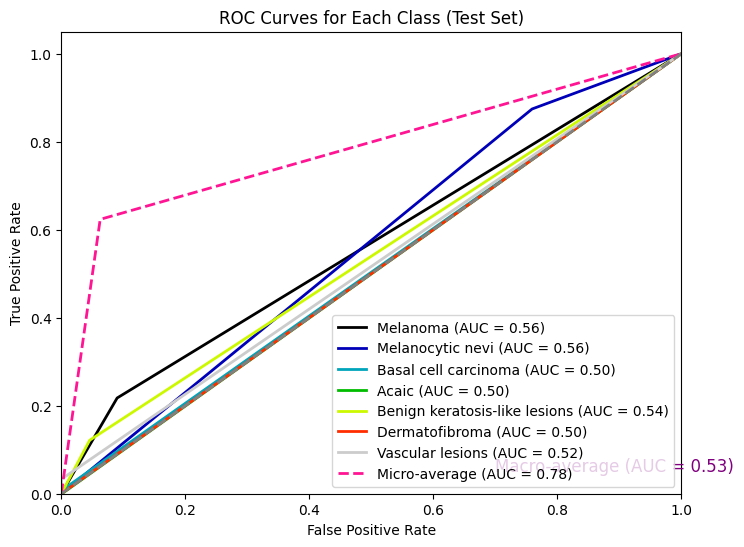

In [ ]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
loaded_model = load_model('/content/drive/MyDrive/DeepLearning/transfer_learning_model.keras')


X_test_resized = tf.image.resize(X_test, size=input_shape)
y_test = y_test.astype(np.float32)
X_test_tensor = tf.convert_to_tensor(X_test_resized)
y_test_tensor = tf.convert_to_tensor(y_test)


y_pred_test = loaded_model.predict(X_test_tensor)

n_classes = y_test_tensor.shape[1]
y_test_binary = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_test_binary = label_binarize(y_pred_test.argmax(axis=1), classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_test_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and AUC
micro_fpr, micro_tpr, _ = roc_curve(y_test_binary.ravel(), y_pred_test_binary.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Macro-average AUC
macro_auc = np.mean(list(roc_auc.values()))

plt.figure(figsize=(8, 6))
colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_classes))
class_names = ["Melanoma", "Melanocytic nevi", "Basal cell carcinoma", "Acaic", "Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(micro_fpr, micro_tpr, color='deeppink', linestyle='--', lw=2, label=f'Micro-average (AUC = {micro_auc:.2f})')

# Plot macro-average AUC
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.text(0.7, 0.05, f'Macro-average (AUC = {macro_auc:.2f})', color='purple', fontsize=12)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class (Test Set)')
plt.legend(loc='lower right')
plt.show()



Transfer Learning Model: Recall, Precision, F1



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


n_classes = y_test.shape[1]
y_test_classes = np.argmax(y_test, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

precision = precision_score(y_test_classes, y_pred_test_classes, average=None)
recall = recall_score(y_test_classes, y_pred_test_classes, average=None)
f1 = f1_score(y_test_classes, y_pred_test_classes, average=None)

for i in range(n_classes):
    print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")

# If you want micro, macro, or weighted averages, you can use:
precision_micro = precision_score(y_test_classes, y_pred_test_classes, average='micro')
recall_micro = recall_score(y_test_classes, y_pred_test_classes, average='micro')
f1_micro = f1_score(y_test_classes, y_pred_test_classes, average='micro')

precision_macro = precision_score(y_test_classes, y_pred_test_classes, average='macro')
recall_macro = recall_score(y_test_classes, y_pred_test_classes, average='macro')
f1_macro = f1_score(y_test_classes, y_pred_test_classes, average='macro')

precision_weighted = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
recall_weighted = recall_score(y_test_classes, y_pred_test_classes, average='weighted')
f1_weighted = f1_score(y_test_classes, y_pred_test_classes, average='weighted')

print("\nMicro Average - Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision_micro, recall_micro, f1_micro))
print("Macro Average - Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision_macro, recall_macro, f1_macro))
print("Weighted Average - Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision_weighted, recall_weighted, f1_weighted))


Class 0 - Precision: 0.2464, Recall: 0.2176, F1 Score: 0.2311
Class 1 - Precision: 0.6985, Recall: 0.8744, F1 Score: 0.7766
Class 2 - Precision: 0.1667, Recall: 0.0094, F1 Score: 0.0179
Class 3 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class 4 - Precision: 0.2336, Recall: 0.1214, F1 Score: 0.1597
Class 5 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class 6 - Precision: 0.5000, Recall: 0.0333, F1 Score: 0.0625

Micro Average - Precision: 0.6236, Recall: 0.6236, F1 Score: 0.6236
Macro Average - Precision: 0.2636, Recall: 0.1794, F1 Score: 0.1783
Weighted Average - Precision: 0.5363, Recall: 0.6236, F1 Score: 0.5647


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transfer Learning Model: Confusion Matrix on Test Set

63/63 [==============================] - 7s 115ms/step


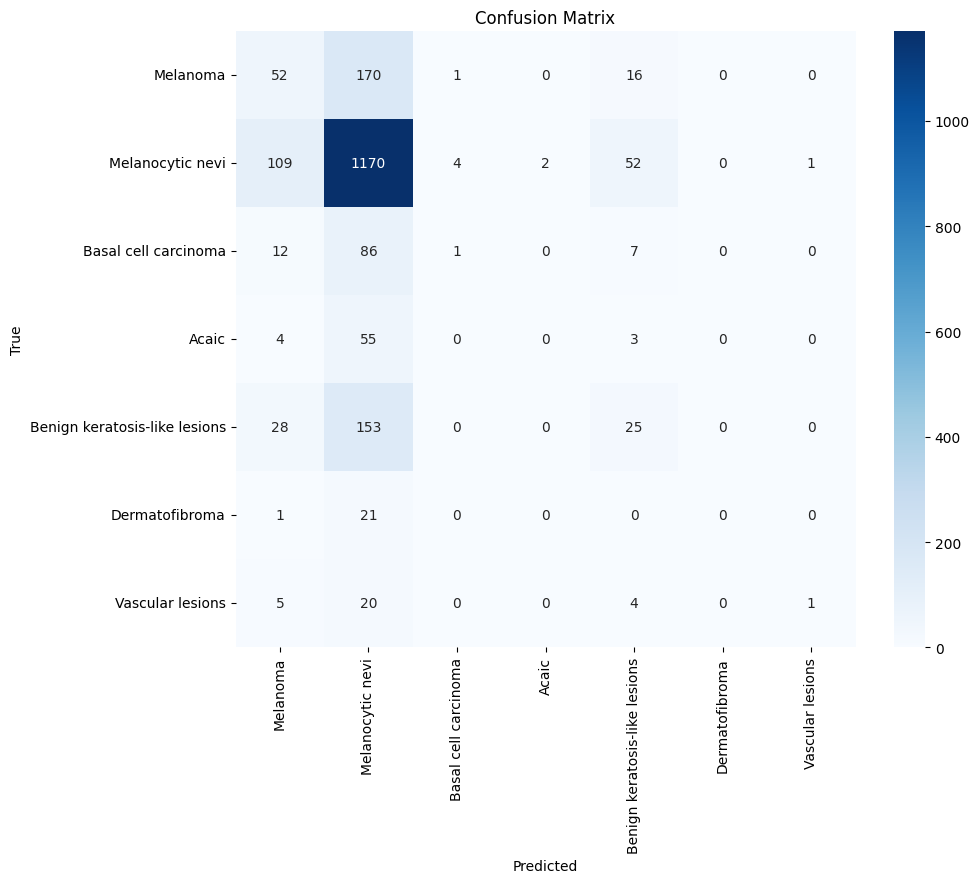

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize

X_test_resized = tf.image.resize(X_test, size=input_shape)
y_test = y_test.astype(np.float32)
X_test_tensor = tf.convert_to_tensor(X_test_resized)
y_test_tensor = tf.convert_to_tensor(y_test)


y_pred_test = loaded_model.predict(X_test_tensor)

n_classes = y_test_tensor.shape[1]
y_test_binary = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_test_binary = label_binarize(y_pred_test.argmax(axis=1), classes=np.arange(n_classes))

y_test_classes = np.argmax(y_test_binary, axis=1)
y_pred_classes = np.argmax(y_pred_test_binary, axis=1)

class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}

confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

